In [1]:
# relevant imports
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from matplotlib import rcParams
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
import os
import seaborn as sns
import sklearn as sk
import math
import pandas as pd
import pickle

In [2]:
# change the working directory to be the timecourse data
#os.chdir('/mnt/Data1/linjdata1/vswmda/scan_data/rsa/full_GLM_mgs_0.05_50/')
os.chdir('/gpfs/scratch/linjjiang/scan_data/rsa/full_GLM_mgs_topN/')
#os.chdir('/gpfs/scratch/linjjiang/scan_data/rsa/full_GLM_atlas_roi/')

In [3]:
subjects = ['f09','f10','f11','f12','f15','f16','f17','f18','f19']
epochs = ['delay','response','stimulus']
exp1_subjects = ['f09','f10','f11','f12','f15','f16']
exp2_subjects = ['f17','f18','f19']

In [4]:
# get ROI name
# # if full_GLM_atlas_roi
# order = ['area4-ju50',        
#           'v1-wang25','v2-wang25',
#           'ips0-wang15','ips1-wang15','ips2-wang15','ips3-wang15',
#           'ips4-wang15','ips5-wang15','spl1-wang15','ips-wang15',
#          'fef-wang25','spcs-md','ipcs-md','pmfg-md','amfg-md','ifg-md'
#           ] 
#          #'area8-hcp','area9-hcp','area9|46-hcp','area44|45|47l-hcp','fef-hcp',


# # for atlas_roi:
# order_full = ['area4-ju50',        
#           'v1-wang25','v2-wang25',
#           'ips0-wang15','ips1-wang15','ips2-wang15','ips3-wang15',
#           'ips4-wang15','ips5-wang15','spl1-wang15','ips-wang15',
#          'fef-wang25','spcs-md','ipcs-md','pmfg-md','amfg-md','ifg-md',
#               'area8-hcp','area9-hcp','area9|46-hcp','area44|45|47l-hcp','fef-hcp'
#           ] 
#          #'area8-hcp','area9-hcp','area9|46-hcp','area44|45|47l-hcp','fef-hcp',
    
    
# if full_GLM_mgs_xxx
order = ['area4', 'v1', 'v2', 'ips', 'fef', 'sfg', 'mfg', 'ifg',
         'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5', 'spl1']
# for mgs roi:
order_full = order

In [5]:
# change the following as needed
roi_labels = {'area4': 'M1', 'v1': 'V1', 'v2': 'V2', 
              
              'ips0': 'IPS0', 'ips1': 'IPS1', 'ips2': 'IPS2', 
              'ips3': 'IPS3', 'ips4': 'IPS4', 'ips5': 'IPS5', 'spl1': 'SPL1',
              
          'ips': 'IPS', 'fef': 'FEF', 'sfg': 'SFG', 
          'mfg': 'MFG', 'ifg': 'IFG'}

# roi_labels = {'area4-ju50': 'M1-Julich', 'v1-wang25': 'V1-Wang25', 'v2-wang25': 'V2-Wang25', 
              
#               'ips0-wang15': 'IPS0-Wang15', 'ips1-wang15': 'IPS1-Wang15', 'ips2-wang15': 'IPS2-Wang15', 
#               'ips3-wang15': 'IPS3-Wang15', 'ips4-wang15': 'IPS4-Wang15', 'ips5-wang15': 'IPS5-Wang15', 
#               'spl1-wang15': 'SPL1-Wang15',
              
#           'ips-wang15': 'IPS-Wang15', 'fef-wang25': 'FEF-Wang25', 'spcs-md': 'sPCS-MD', 
#           'ipcs-md': 'iPCS-MD', 'amfg-md': 'aMFG-MD', 'pmfg-md': 'pMFG-MD','ifg-md': 'IFG-MD'}

# roi_order = list(roi_labels.values())
subj_labels = {index: subject for index, subject in enumerate(subjects, start=0)}
epoch_labels = {0: 'stimulus', 1: 'delay', 2: 'response'}

In [95]:
# # let's plot!
from matplotlib.patches import Patch
def plot_group_dsm(df,title,roi_labels,subjects,epoch_labels,data_palette):
    roi_order = list(roi_labels.values())

    subj_labels = {index: subject for index, subject in enumerate(subjects, start=0)}
        
    # Define color-blind friendly palettes
    # data_palette = ['#A9A9A9','#808080', '#A9A9A9','#808080','#A9A9A9']  #sns.color_palette("colorblind", 2) #'#D3D3D3', 
    # A distinct color palette for participants
    participant_palette = sns.color_palette("colorblind", df['subj'].unique().shape[0])

    # Offset for the scatter points to align with the bar centers
    metrics = df['data_label'].unique()
    num_metrics = len(metrics)
    data_offsets = {metric: (i - (num_metrics - 1) / 2) * (0.8 / num_metrics) for i, metric in enumerate(metrics)}

    
    # Function to plot scatter points and connecting lines
    def scatter_and_lines(data, **kwargs):
        ax = plt.gca()
        
        # Plot scatter points
        for lbl, offset in data_offsets.items():
            subset = data[data['data_label'] == lbl]
            x_coords = [roi_order.index(roi) + offset for roi in subset['roi']]
            sns.scatterplot(x=x_coords, y=subset['data'], hue=subset['subj'], palette=participant_palette, 
                            style=subset['data_label'], edgecolor='black', s=50, ax=ax, alpha=1, 
                            zorder=3,**kwargs)
        # Plot connecting lines
        for _, group in data.groupby(['subj', 'roi']):
            participant_index = list(subj_labels.values()).index(group['subj'].iloc[0])  # Use integer index to access the palette
            x_coords = [roi_order.index(roi) + data_offsets[lbl] for roi, lbl in zip(group['roi'], group['data_label'])]
            ax.plot(x_coords, group['data'], color=participant_palette[participant_index], linewidth=2, 
                    linestyle='--', alpha=1,zorder=2)
            
    # Plotting
    task_epoch_order = ["Stimulus", "Delay"]
    
    plt.figure(figsize=(40, 12))
    g = sns.FacetGrid(df, col="epoch", col_order=task_epoch_order, col_wrap=1, height=4, aspect=4)
    g.map_dataframe(sns.barplot, x='roi', y='data', hue='data_label',
                    order=roi_order,errorbar=None,dodge=True, palette=data_palette,zorder=1) #hue='session',
    g.map_dataframe(scatter_and_lines) #alpha=0.3,
    
    # Adjust transparency of error bars
#     for ax in g.axes.flat:
#         for line in ax.get_lines():  # Lines for error bars
#             line.set_alpha(0.3)
    
    # Adjusting the labels and titles
    g.set_axis_labels("Regions of Interest (ROI)", "Correlation distance")
    g.set_titles(col_template="{col_name}", row_template="")

    # # Setting an overall title
    # g.fig.suptitle("Comparison of ROI Values Across Sessions and Task Epochs", fontsize=16)
    plt.xticks(rotation=45)
    
    # Adjusting the legend
    for ax in g.axes.flat:
        if ax.legend_:
            ax.legend_.remove()
        #ax.axhline(0, color='black', linestyle='--', linewidth=2)

    # Manually create a legend
    handles, labels = [], []
#     for participant, color in zip(subj_labels.values(), participant_palette):
#         handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, alpha = 1, markersize=10, label=participant))
    
    metric_labels = ['Between-session, Between-condition','Between-session, Within-condition',
                    'Within-session, Between-condition','Within-session, Within-condition',
                    'Within-run, Between-condition']
    
    for idx,lbl in enumerate(metrics):
        handles += [
            Patch(facecolor=data_palette[idx], edgecolor='black', label=metric_labels[idx], alpha=1)
        ] #
    
    # Adjusting font sizes for axes
    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
        ax.set_title(ax.get_title(), fontsize=22)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

    # # Adjust layout to make room for the overall title
    # plt.subplots_adjust(top=0.9)

    #g.fig.legend(handles=handles, ncol=1,bbox_to_anchor=(1.2, 1))
    g.fig.legend(handles=handles, ncol=3, bbox_to_anchor=(1.05,1.2),fontsize=20,frameon=False) #bbox_to_anchor=(1.1, 1)
    
    plt.show()
    g.savefig(title,bbox_inches = 'tight',dpi=300)
    

In [96]:
from pathlib import Path
def plot_dissimilarity_value(subjects,filenames):
    for filename in filenames:
        file_path = Path('corr_distance_across_run_sess_pat_'+filename+'.pkg')

        with open(os.path.join('corr_distance_across_run_sess_pat_'+filename+'.pkg'),'rb') as f:
            [df1,df2,df3] = pickle.load(f)

        data_palette = sns.color_palette("tab20", 5) #= ['#C0C0C0','#808080', '#C0C0C0','#808080','#C0C0C0'] #C0C0C0, A9A9A9, 808080
        
        df1 = df1[df1['epoch'] != 'response']
        
        epoch_map = {'stimulus':'Stimulus','delay':'Delay'}
        df1['epoch'] = df1['epoch'].map(epoch_map)
        epoch_labels = {0: 'Stimulus', 1: 'Delay'}

        plot_group_dsm(df1,'btw_wit_sess_run_pat_'+filename+'.png',roi_labels,subjects,epoch_labels,data_palette)
        

<Figure size 4000x1200 with 0 Axes>

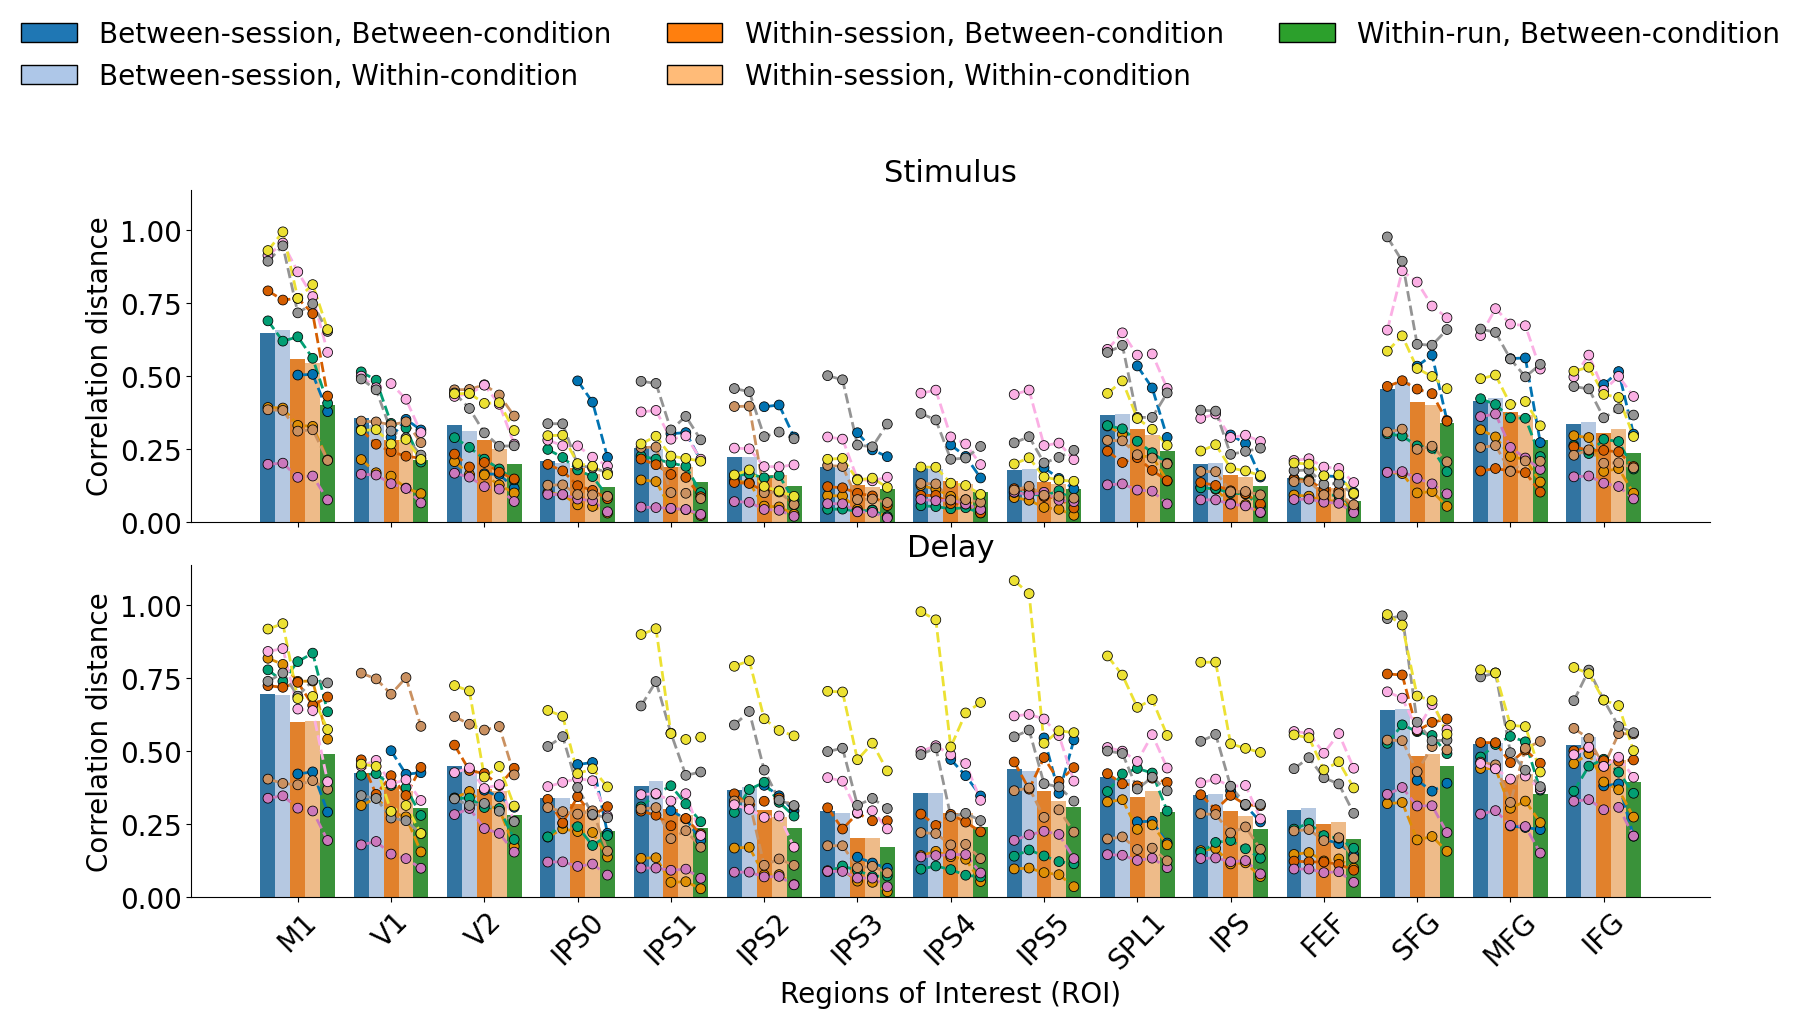

<Figure size 4000x1200 with 0 Axes>

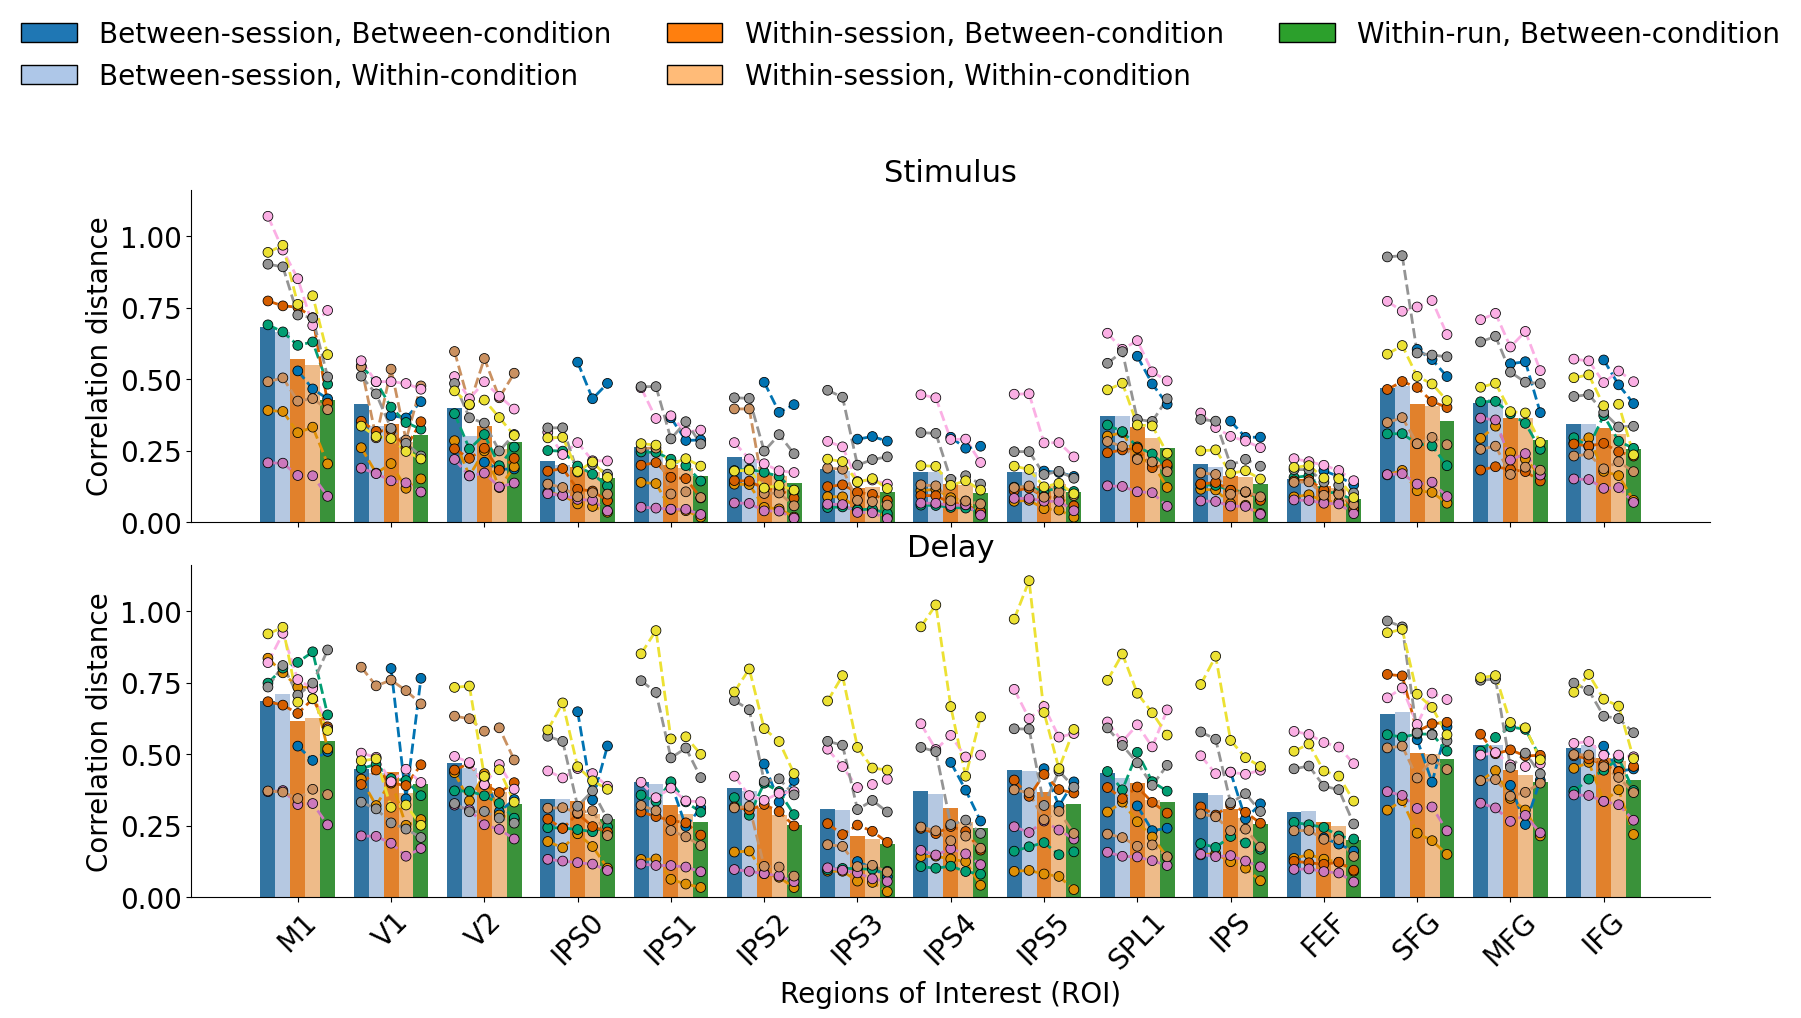

In [97]:
plot_dissimilarity_value(subjects,['LR','WT']) #['LR','WT']

/gpfs/software/Anaconda/envs/jupyter/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/gpfs/software/Anaconda/envs/jupyter/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)


<Figure size 4000x1200 with 0 Axes>

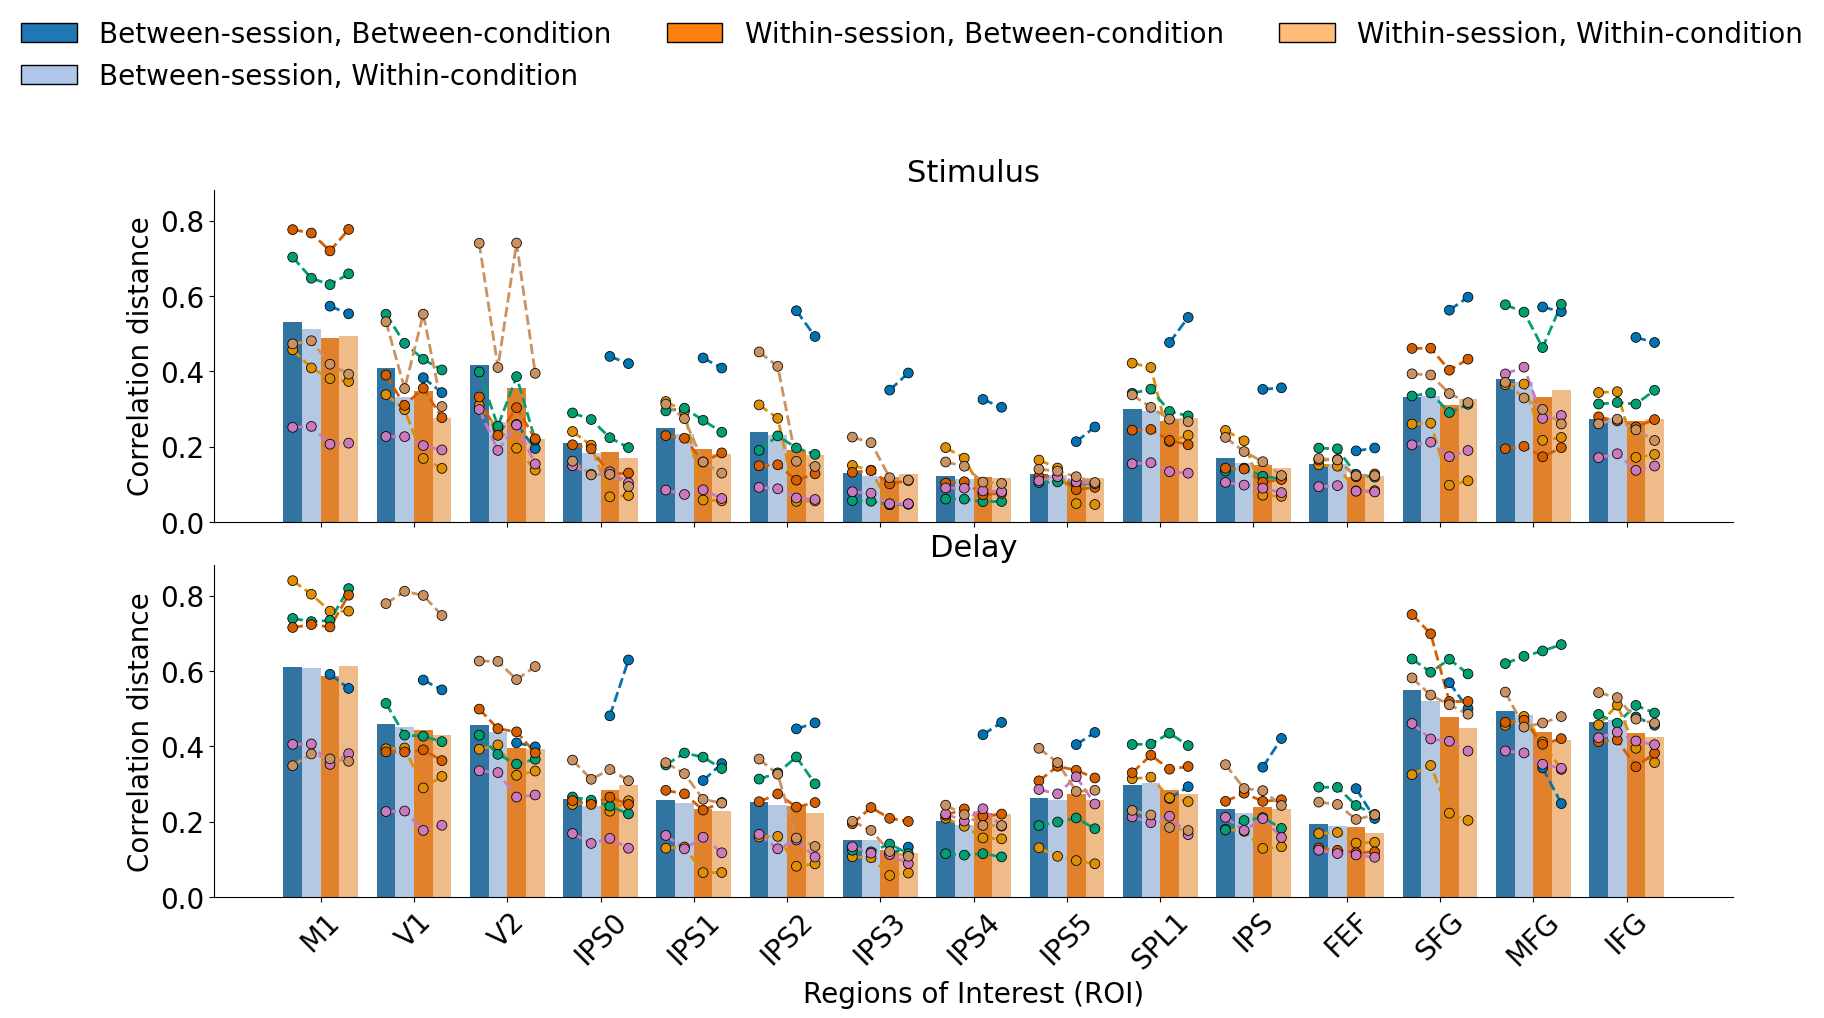

In [98]:
plot_dissimilarity_value(exp1_subjects,['ecc']) #['LR','WT']